# 1.군집분석 

- 데이터 경로 /kaggle/input/adp-p7/problem1.csv 

### 데이터 설명
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.     
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.     
- Description: Product (item) name. Nominal.    
- Quantity: The quantities of each product (item) per transaction. Numeric.     
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.   
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.    
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.     
- Country: Country name. Nominal, the name of the country where each customer resides.     


### 데이터 출처
- https://archive.ics.uci.edu/ml/index.php

## 1.1 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/adp-p7/problem1.csv')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41024 entries, 0 to 41023
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    41024 non-null  object 
 1   StockCode    41024 non-null  object 
 2   Description  41024 non-null  object 
 3   Quantity     41024 non-null  int64  
 4   InvoiceDate  41024 non-null  object 
 5   UnitPrice    41024 non-null  float64
 6   CustomerID   41024 non-null  float64
 7   Country      41024 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.5+ MB


In [3]:
# Customer 수 확인
df['CustomerID'].unique().shape

(348,)

In [4]:
# 결측치가 없으므로 바로 F, M feature 생성

# InvoiceDate에서 시간 제거하고 일자만 남기기
df['date'] = pd.to_datetime(df['InvoiceDate']).dt.date
F = df.groupby('CustomerID').count()['date']

df['price'] = df['UnitPrice'] * df['Quantity']
M = df.groupby('CustomerID').sum('price')
M = M['price']

F.to_frame()
M.to_frame()

df_new = pd.concat([F, M], axis = 1)
df_new.columns = ['F', 'M']

In [5]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 348 entries, 12348.0 to 17097.0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F       348 non-null    int64  
 1   M       348 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.2 KB


In [6]:
df_new.describe()

,F,M
count,348.000000,348.000000
mean,117.885057,3960.727356
std,354.247025,18821.144519
min,1.000000,-1126.000000
25%,23.000000,452.000000
50%,51.500000,1008.990000
75%,113.250000,2760.185000
max,5903.000000,279489.020000


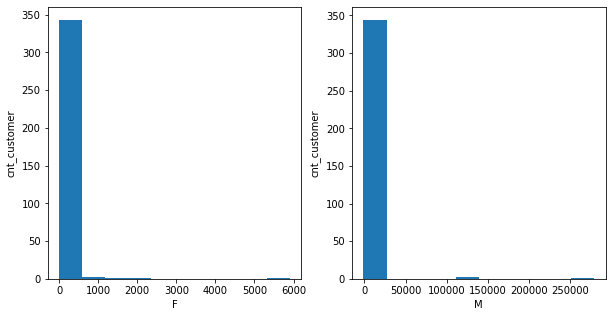

In [7]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.hist(df_new['F'])
plt.xlabel('F')
plt.ylabel('cnt_customer')

plt.subplot(1, 2, 2)
plt.hist(df_new['M'])
plt.xlabel('M')
plt.ylabel('cnt_customer')
plt.show()

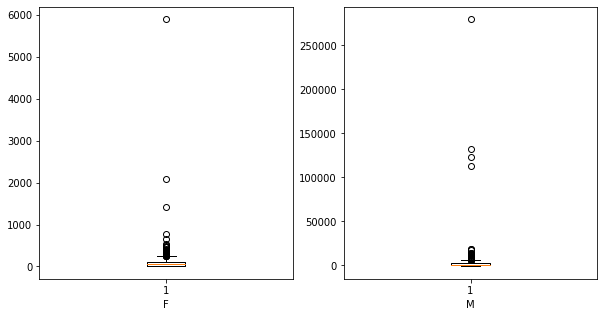

In [8]:
# 상자그림을 통한 이상치 확인
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(df_new['F'])
plt.xlabel('F')

plt.subplot(1, 2, 2)
plt.boxplot(df_new['M'])
plt.xlabel('M')
plt.show()

## 1.2 F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정

In [9]:
# Invoice 유니크한 값 구하기
df['InvoiceDate'].unique().shape

(2084,)

In [10]:
# 2084일까지 살 수 있는데, 5903이 생긴 것은 이상하다.
# 따라서 F 변수에서 2084가 넘는 값 몇 개인지 확인

df_new[df_new['F'] > 2084]['F'].count()

2

In [11]:
# 2개 이므로 삭제한다.

df_new = df_new[df_new['F'] <= 2084]
df_new.describe()

,F,M
count,346.000000,346.000000
mean,95.479769,2792.692139
std,132.255510,9323.618593
min,1.000000,-1126.000000
25%,23.000000,450.300000
50%,51.000000,1002.555000
75%,111.000000,2697.665000
max,1420.000000,123725.450000


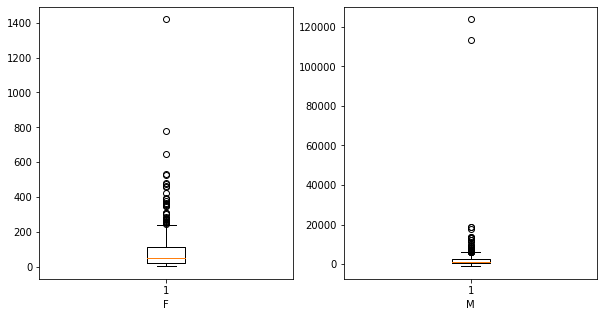

In [12]:
# 다시 상자그림 그려보기
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(df_new['F'])
plt.xlabel('F')

plt.subplot(1, 2, 2)
plt.boxplot(df_new['M'])
plt.xlabel('M')
plt.show()

### 군집분석 실시 (feat.비계층적 군집분석)

k-means 군집분석

In [13]:
# 군집분석 하기 전에 스케일링
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df_new_scaled = pd.DataFrame(scaler.fit_transform(df_new), columns = df_new.columns)

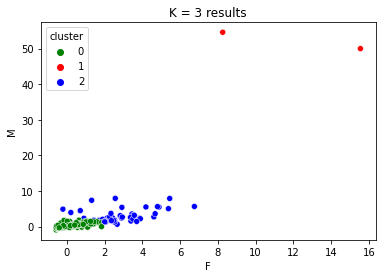

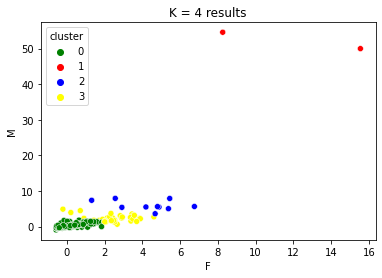

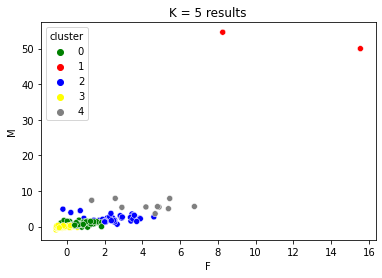

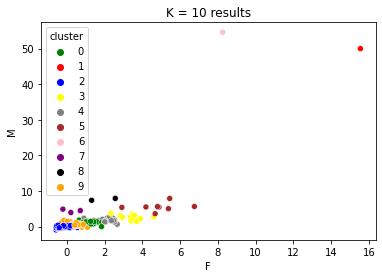

In [14]:
# 시각화랑 같이 하기
from sklearn.cluster import KMeans
import seaborn as sns

k = [3, 4, 5, 10]
palette = ['green', 'red', 'blue', 'yellow', 'gray', 'brown', 'pink', 'purple', 'black', 'orange']
for i in k:
    model = KMeans(n_clusters = i, random_state = 731)
    model.fit(df_new_scaled)
    df_new_scaled['cluster'] = model.fit_predict(df_new_scaled)
    sns.scatterplot(x='F', y='M', hue = 'cluster', data = df_new_scaled, palette = palette[:i])
    plt.title('K = %d results'%i)
    plt.show()

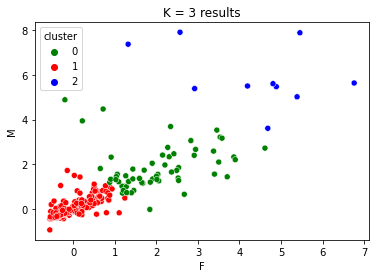

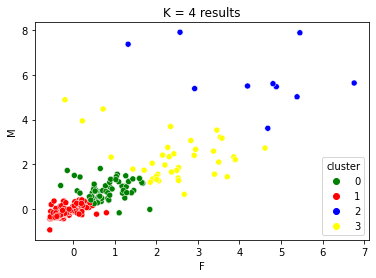

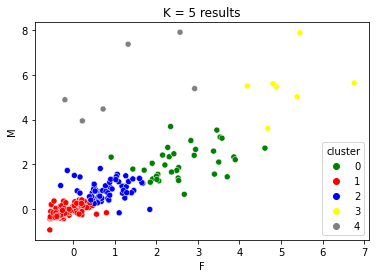

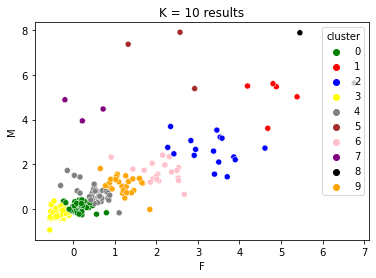

In [15]:
# 저 위에 두 점을 없애고 다시 해야할 것 같음
df_new_scaled.pop('cluster')
df_new_scaled = df_new_scaled[df_new_scaled['F'] < 8]

k = [3, 4, 5, 10]
palette = ['green', 'red', 'blue', 'yellow', 'gray', 'brown', 'pink', 'purple', 'black', 'orange']
for i in k:
    model = KMeans(n_clusters = i, random_state = 731)
    model.fit(df_new_scaled)
    df_new_scaled['cluster'] = model.fit_predict(df_new_scaled)
    sns.scatterplot(x='F', y='M', hue = 'cluster', data = df_new_scaled, palette = palette[:i])
    plt.title('K = %d results'%i)
    plt.show()

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=9), k=(1, 10))

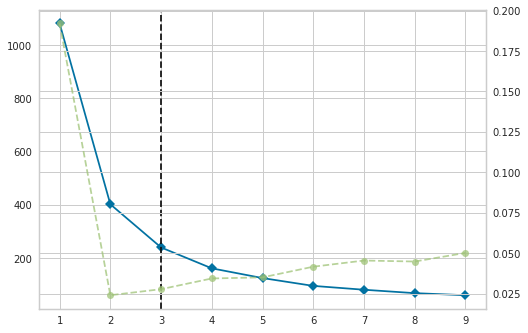

In [16]:
# 보기에는 k=5정도면 괜찮아보이는데, 엘보우 메소드를 이용하여 확인해보기
# scree plot 느낌(주성분 분석)

from yellowbrick.cluster import KElbowVisualizer

df_new_scaled.pop('cluster')

model_test = KMeans()
visualizer = KElbowVisualizer(model_test, k=(1, 10))
visualizer.fit(df_new_scaled)

In [17]:
# 여기서는 k=3을 추천해주긴 하지만, 산점도로 봤을 때 k=5가 마음에 드므로 k=5로 결정한다.

## 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

## 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

# 2번 시계열분석
- 경로 : /kaggle/input/adp-p7/problem2.csv
- 데이터 설명    
  각 raw는 관광지 A의 1990년 1월 부터 25년동안의 매달 평균 이용객 숫자이다.

## 2-1 EDA와 시각화를 진행하라

## 2-2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라

## 2-3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것

## 2-4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

# 3번


## 3-1 서울에서 영동까지 100km/h로 가고 영동에서 서울까지 80km/로 돌아왔을 때, 평균 속도는?

## 3-2 연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가한 것인가?

## 3-3 남성, 여성의 등산, 수영에 대한 취미 선호도 빈도표(2x2)를 보고, 남성 중에서 등산을 좋아할 확률을 구하시오

![image](https://github.com/Datamanim/datarepo/blob/main/adp/25/problem3_3.png?raw=true)

## 3-4 표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정

# 4번 임상 대상 20명에 대해 혈압약 투약 이전과 이후의 차이가 24, 표준편차 9  신뢰구간 95%, 차이가 존재하는지 확인하려한다.

## 4-1 귀무가설과 연구가설을 제시하시오

## 4-2 검정 후 귀무가설 기각 여부 제시

# 5번 공장 X,Y,Z의 평균 출하 소요시간을 여러 일자에 거쳐 측정한 데이터이다. 각 공장의 중위수의 차이가 존재하는지 확인하려 한다.
- problem5.csv

## 5-1. 연구가설과 귀무가설을 설정하시오

## 5-2. 검정통계량을 구하고 가설을 채택하시오

# 6번 1개년 50억원, 2개년 60억원, 3개년 70억원의 예산을 가지고 NPV(순현재가치)가 가장 높아지는 안을 제시하시오.

![image](https://github.com/Datamanim/datarepo/blob/main/adp/25/problem6.png?raw=true)